In [61]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsRegressor
import rasterio as rst
from rasterstats import zonal_stats
import matplotlib.cm as cm

matplotlib.style.use('dark_background')

In [62]:
LA_area_map = gpd.read_file('LAD2017\Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.shp')
master_df = pd.read_csv('C:/Users/Jonathan/OneDrive - University of Bristol/CS/AppliedDataScience/Coursework/ADS-Loneliness/master_df.csv')
#progression_df = pd.read_csv('C:/Users/Jonathan/OneDrive - University of Bristol/CS/AppliedDataScience/Coursework/ADS-Loneliness/Tundra(progression_rates)/outputDataframe.csv')
LA_area_map.head()
print(LA_area_map.loc[LA_area_map['lad17cd'].isin(['E06000029','E06000028','E06000058'])])



    objectid    lad17cd      lad17nm lad17nmw   bng_e  bng_n     long  \
27        28  E06000028  Bournemouth     None  410069  93928 -1.85864   
28        29  E06000029        Poole     None  403393  93466 -1.95327   

          lat    st_areasha    st_lengths  \
27  50.744862  4.617805e+07  48619.722816   
28  50.740780  6.476777e+07  73803.230112   

                                             geometry  
27  MULTIPOLYGON (((407544.800 97837.903, 407548.9...  
28  MULTIPOLYGON (((404608.099 99002.200, 404596.4...  


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_31128/755205140.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize=(12,12))


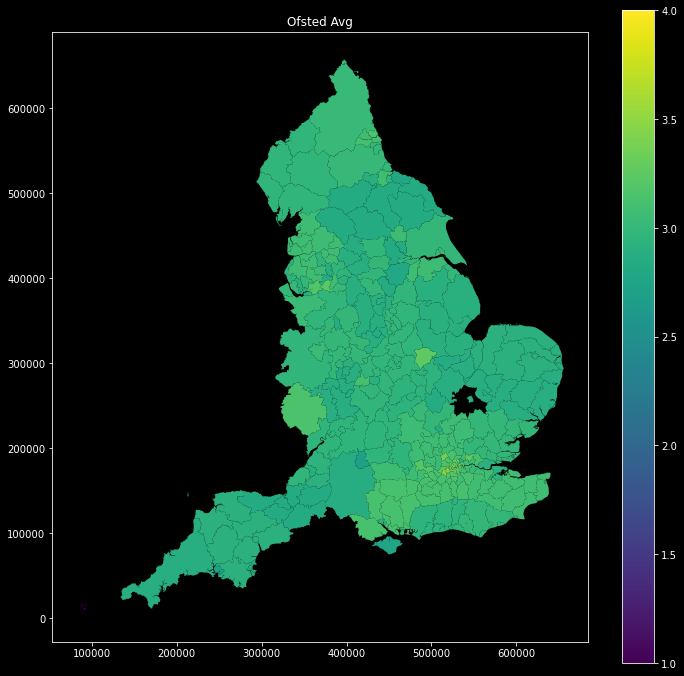

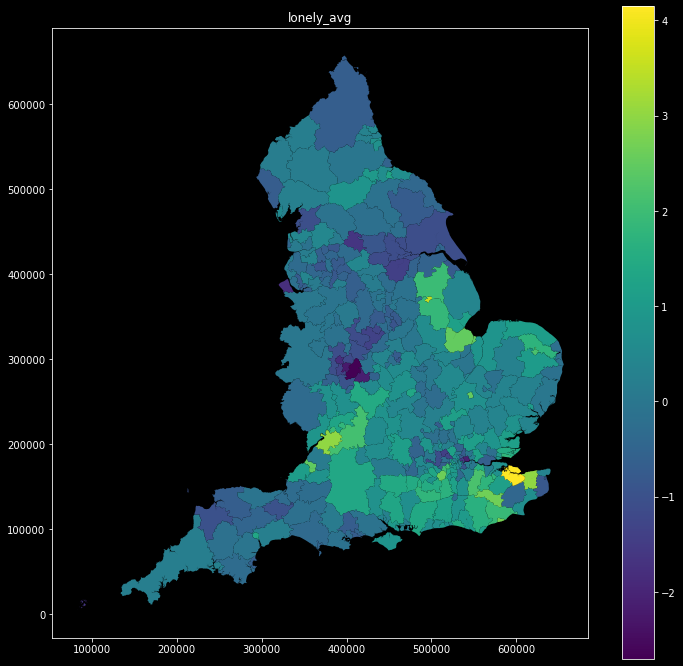

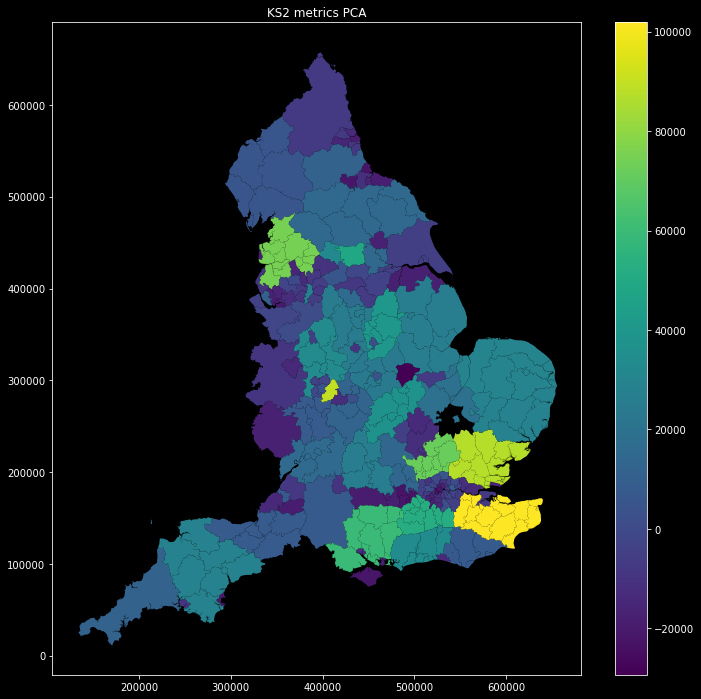

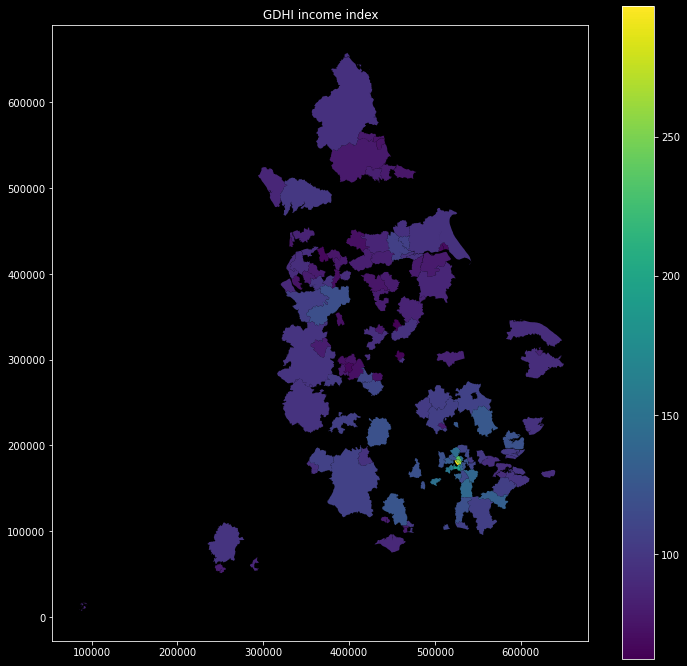

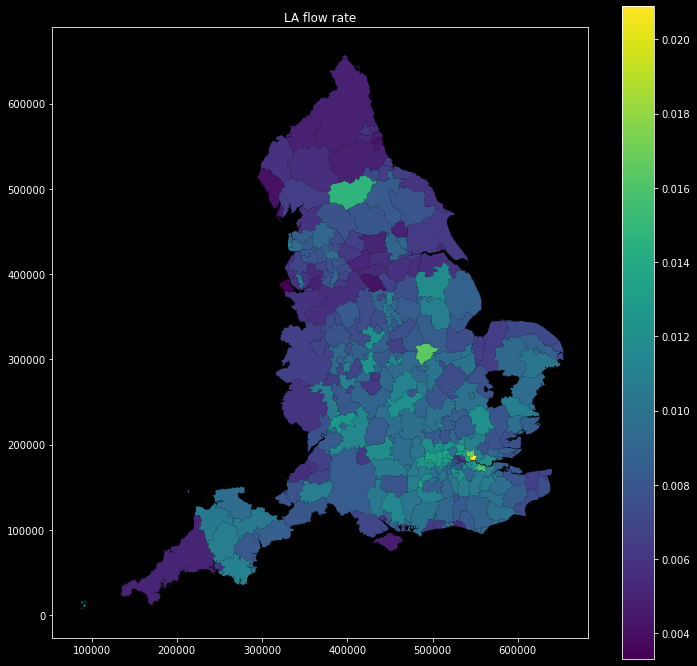

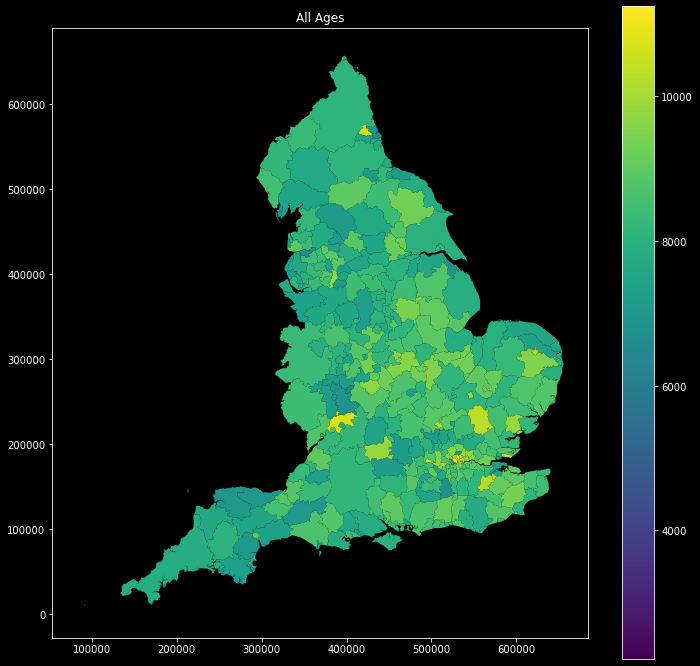

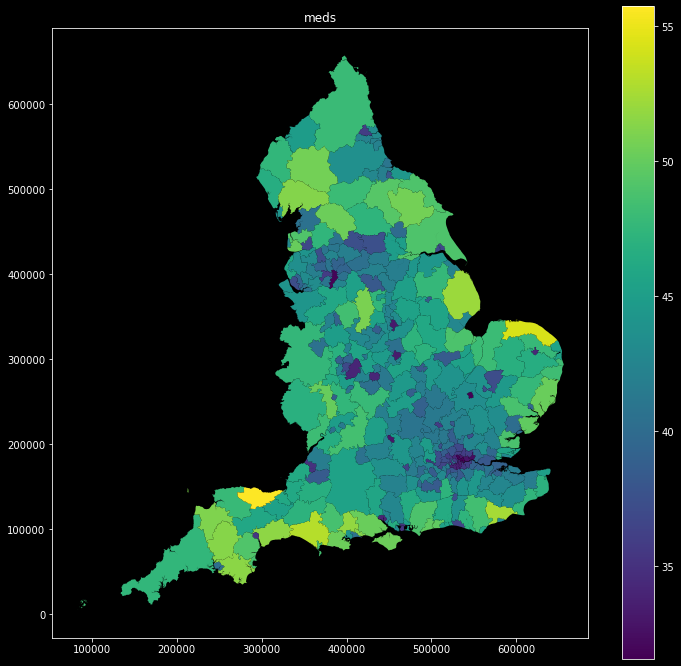

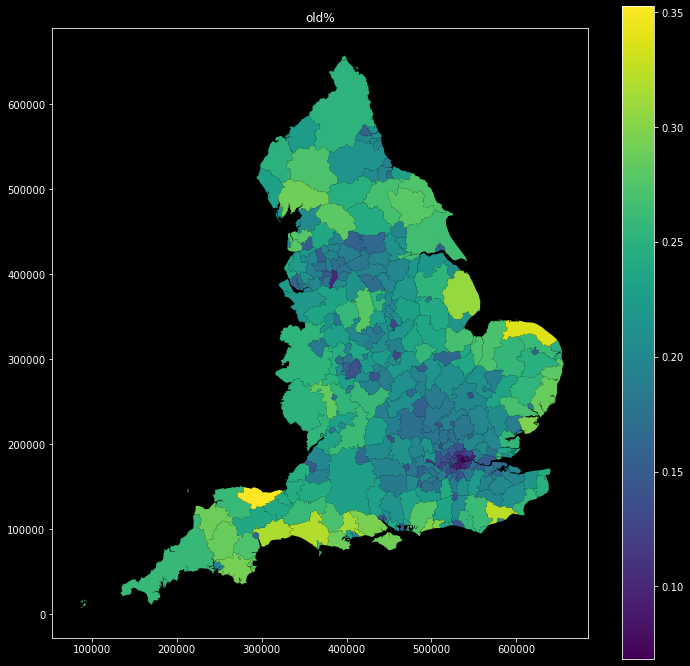

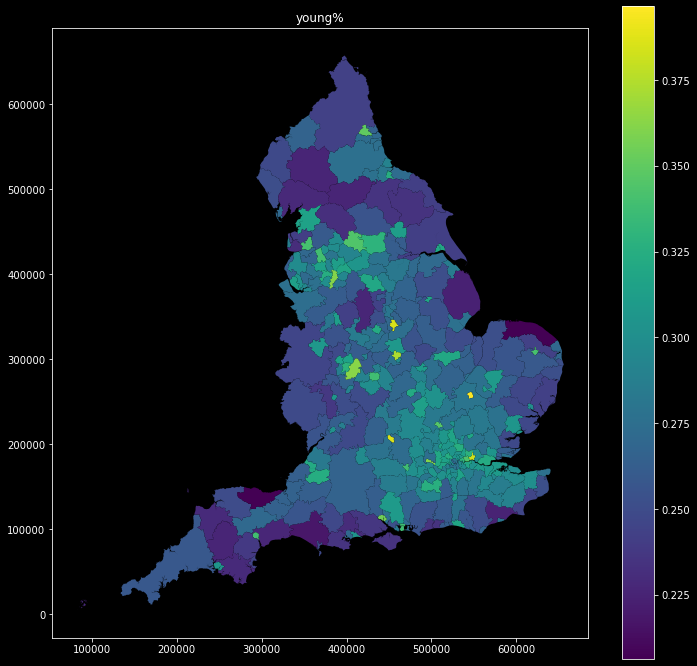

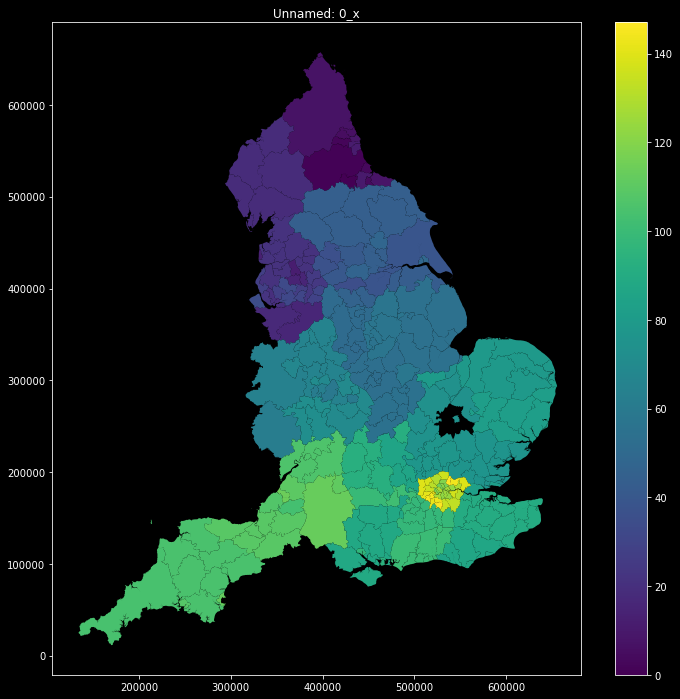

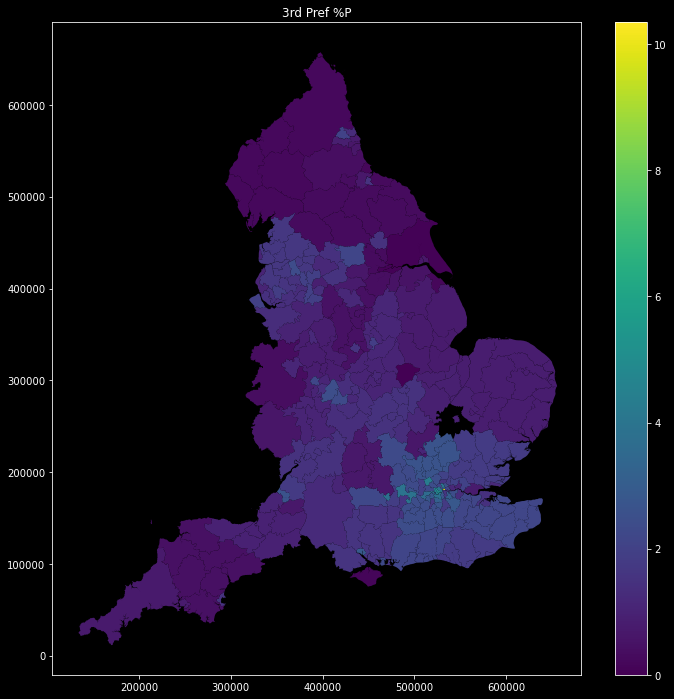

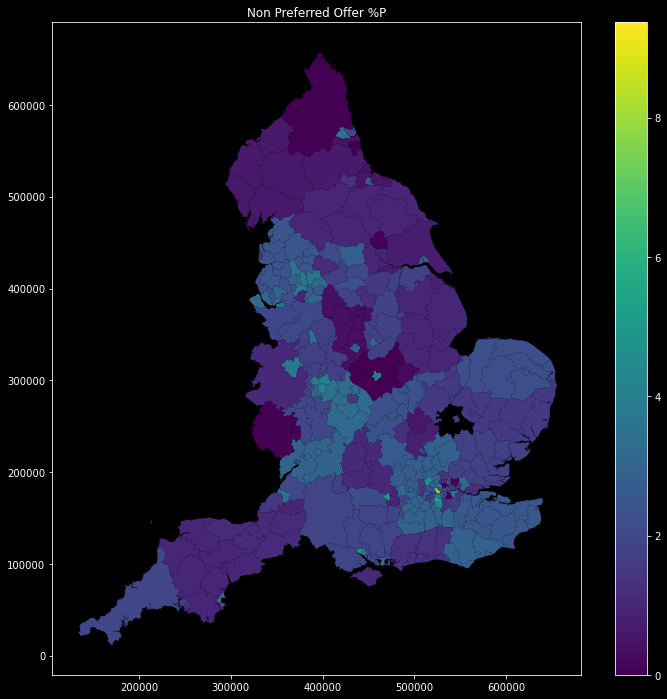

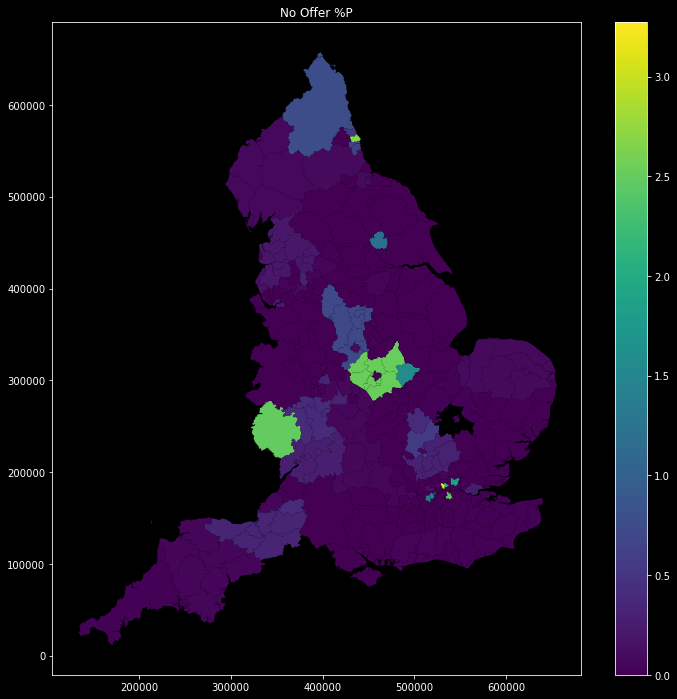

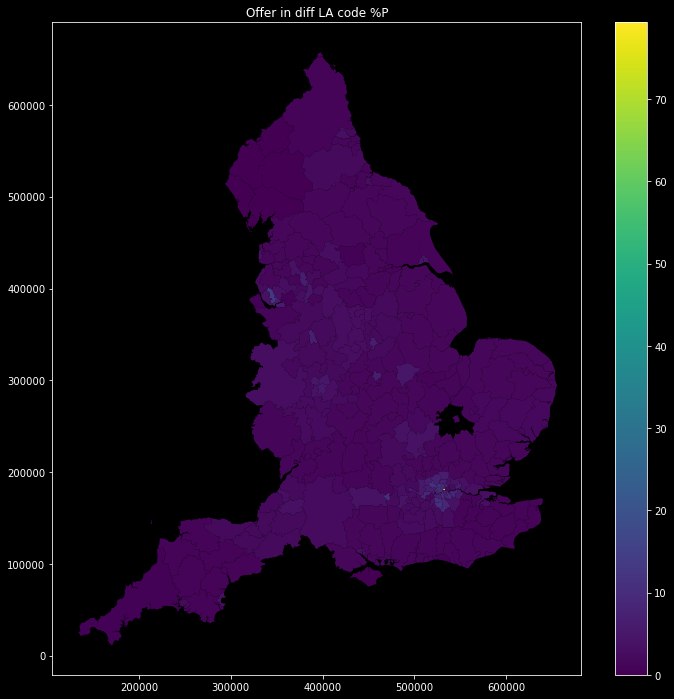

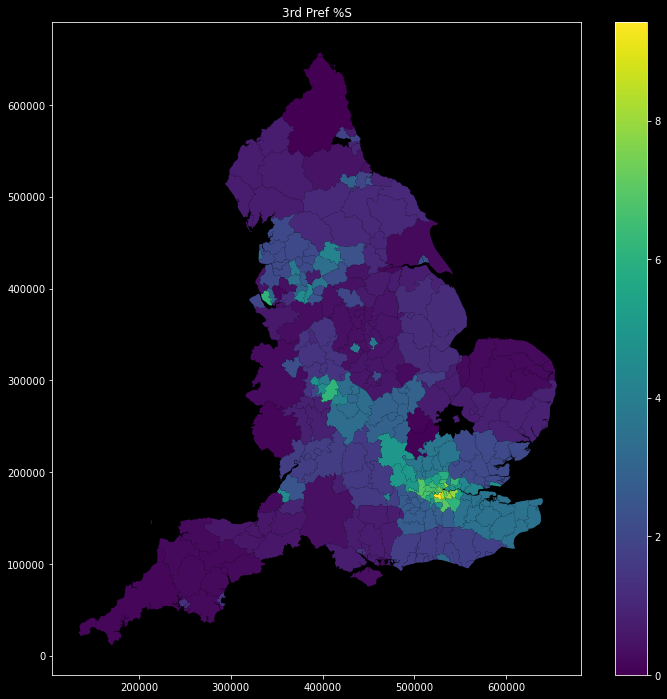

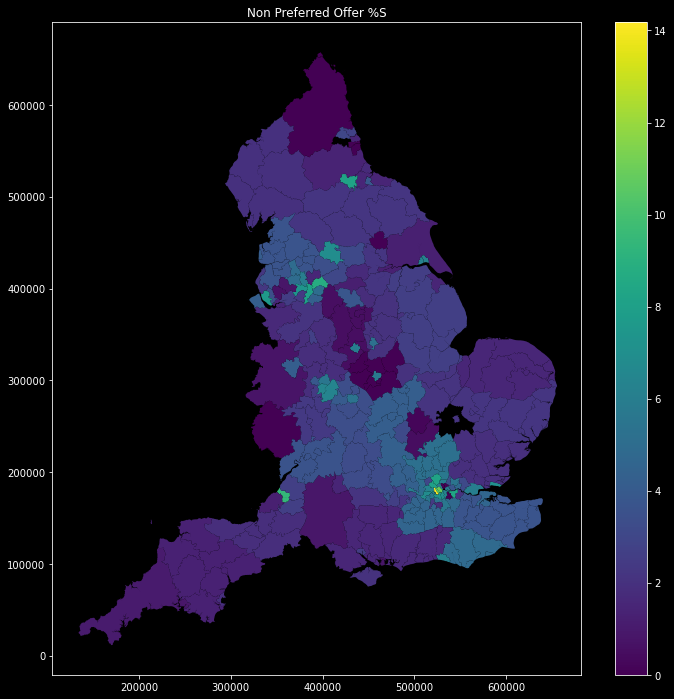

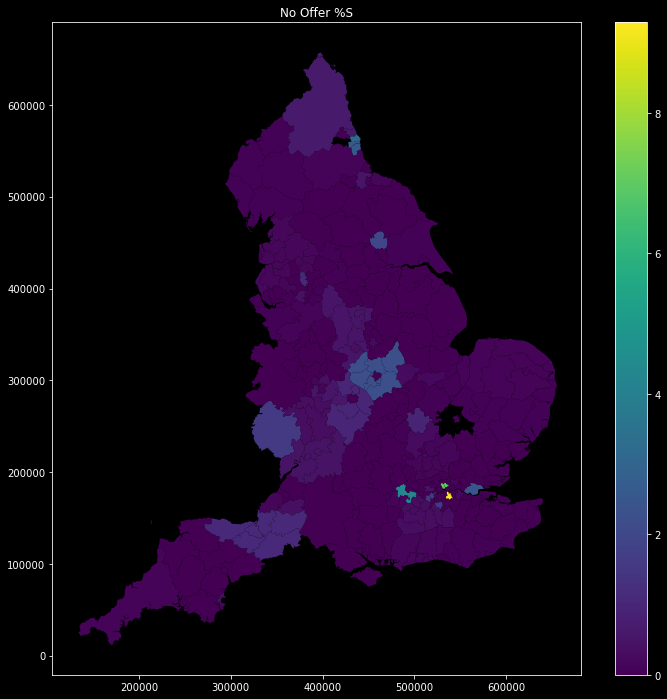

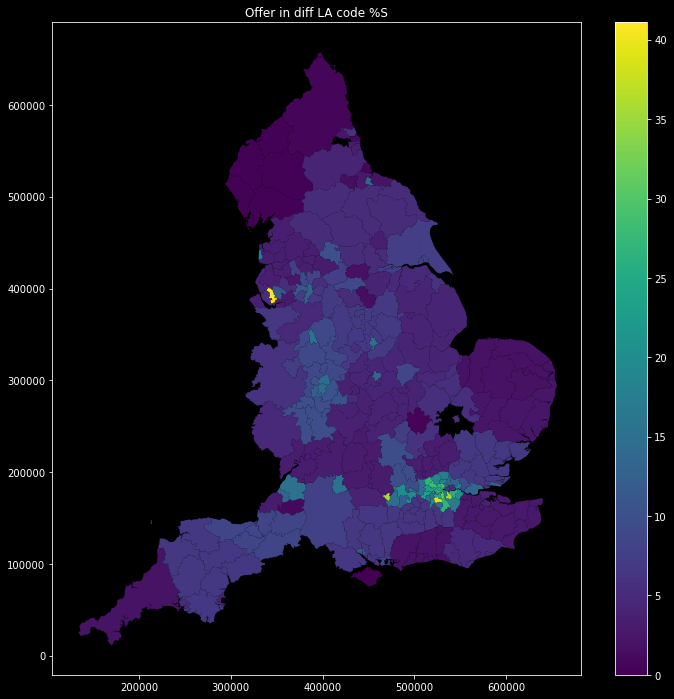

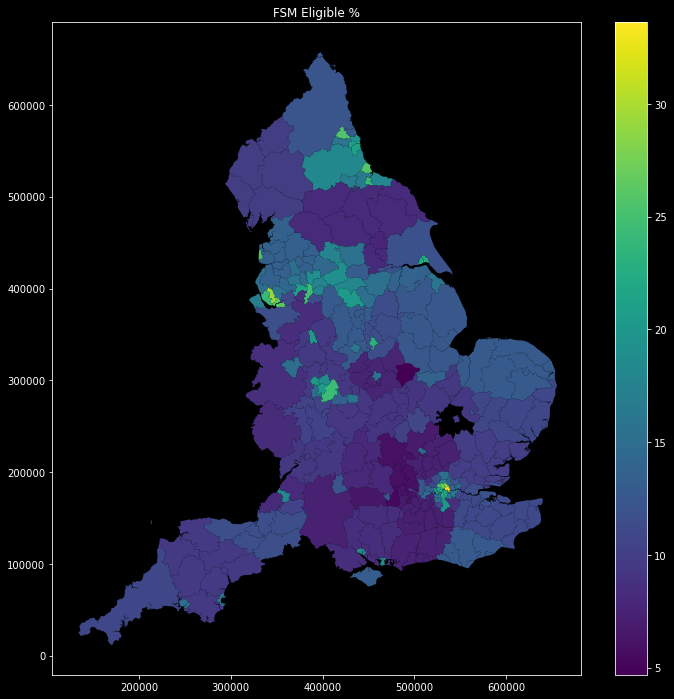

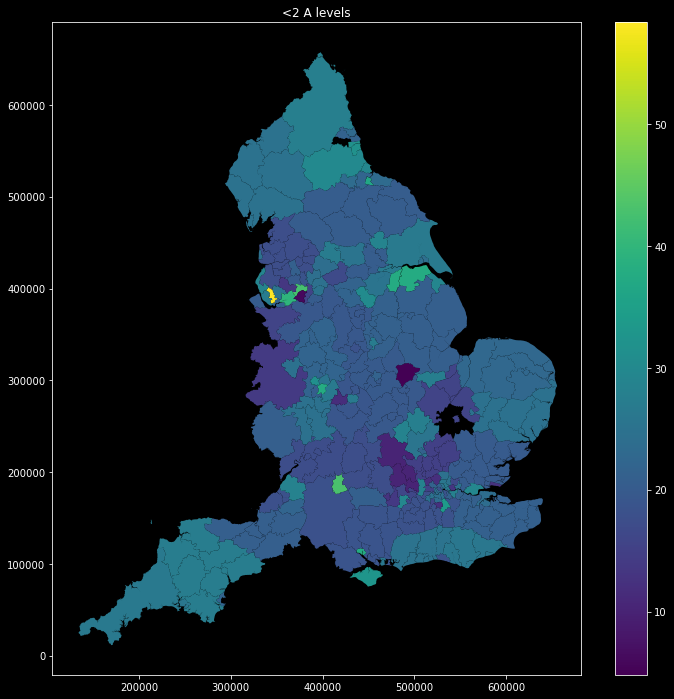

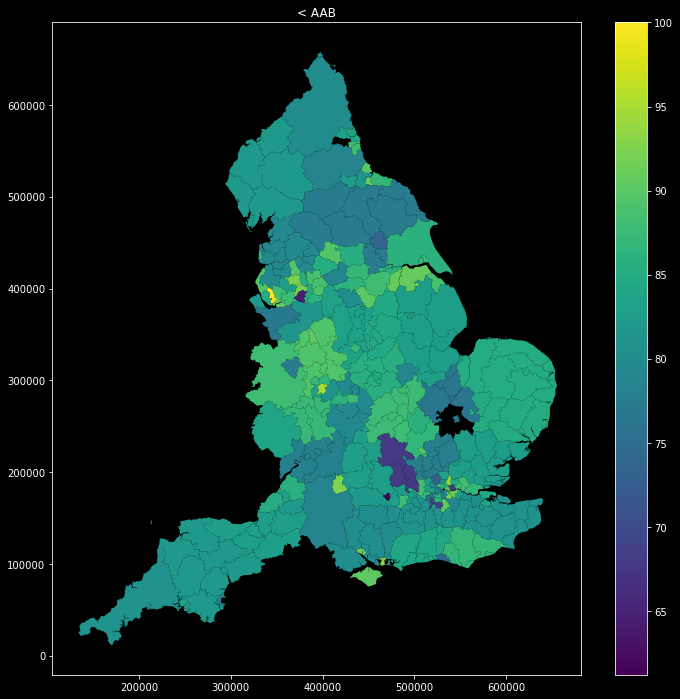

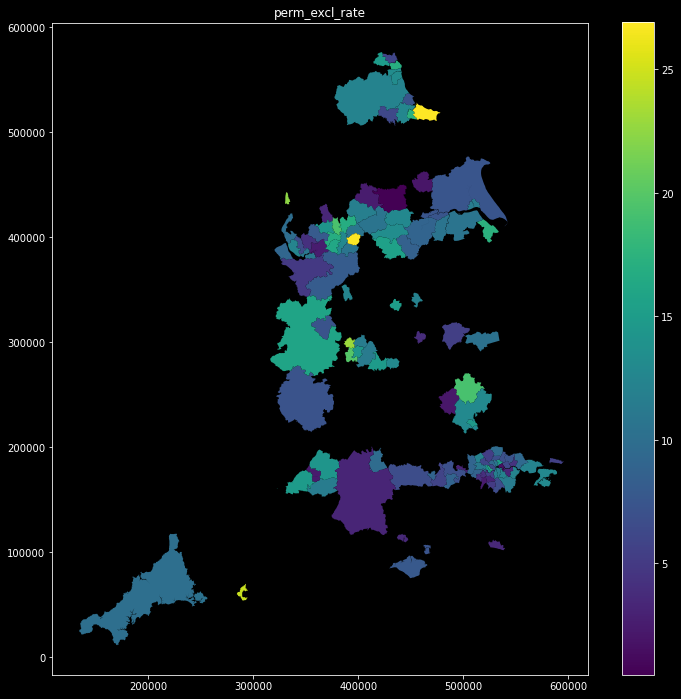

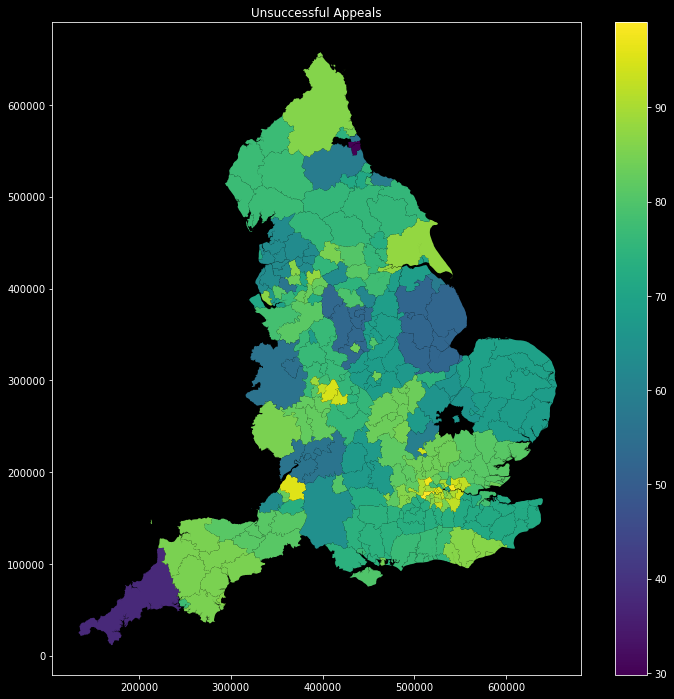

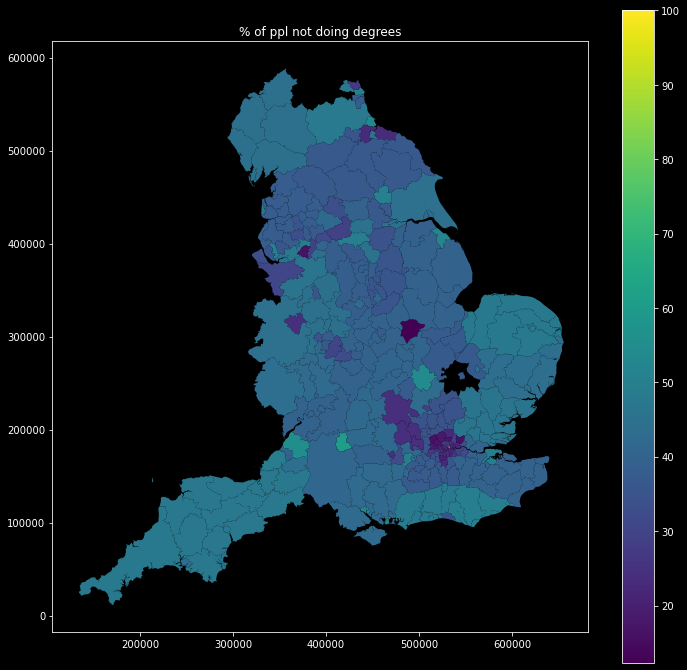

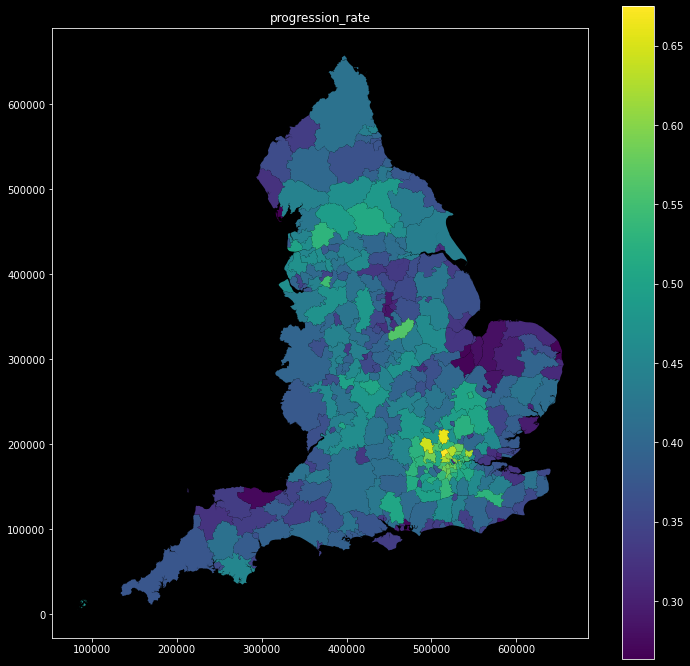

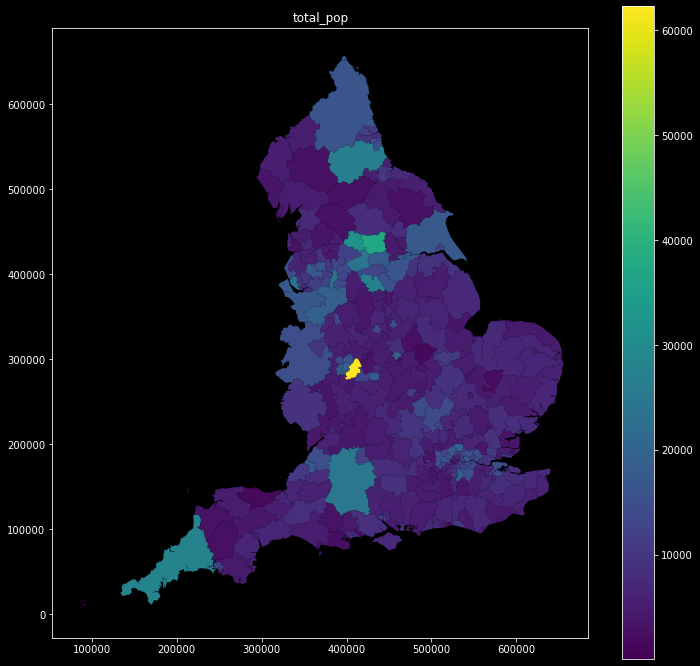

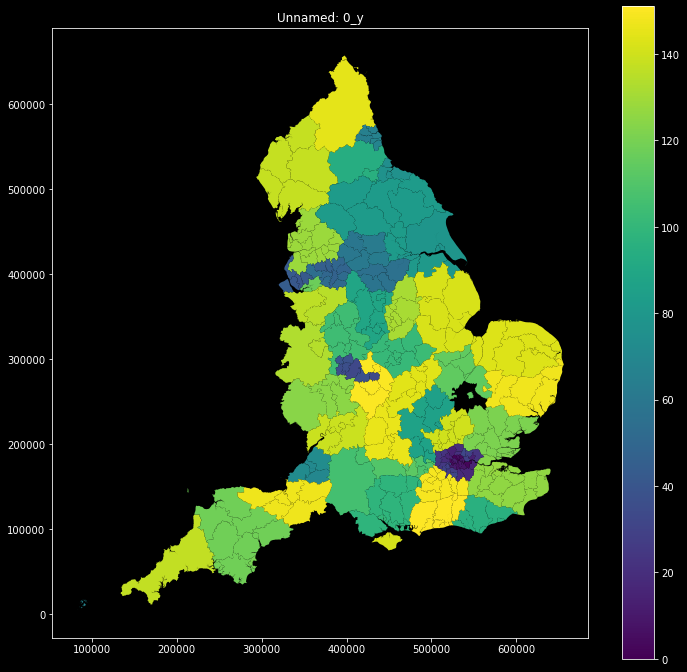

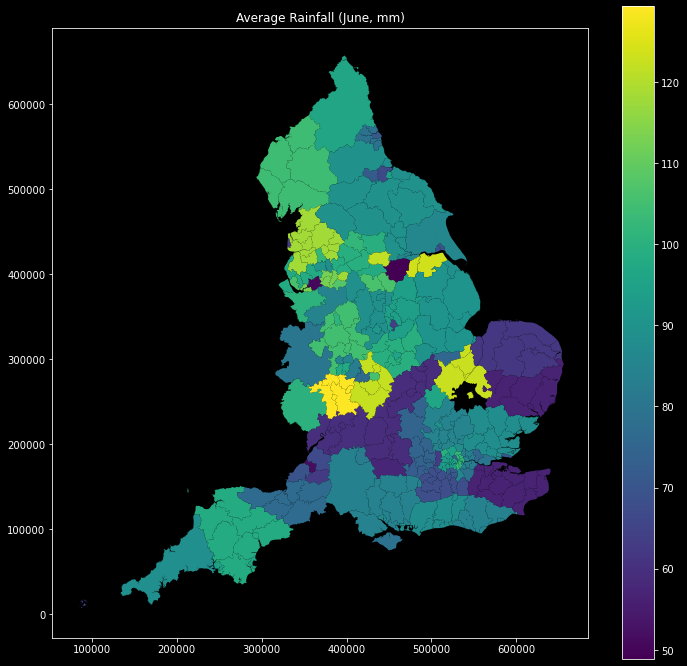

In [63]:
LA_area_map = LA_area_map.rename(columns={'lad17cd':'LA code'})
map_df =LA_area_map.merge(master_df, on='LA code',how='outer')
type(map_df)

for name in map_df.columns[12:]:
    #print(name)
    fig,ax = plt.subplots(figsize=(12,12))
    map_df.plot(ax=ax,column=name,legend=True)
    ax.set_title(name)